In [180]:
import numpy as np
import re
import cv2
import imutils
from imutils.contours import sort_contours
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow as tf

import io
import os
import scipy.misc
import six
import time
import glob
from IPython.display import display

from six import BytesIO

from PIL import Image, ImageDraw, ImageFont

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

import warnings
warnings.filterwarnings('ignore') 

%matplotlib inline

In [178]:
base_path = 'D:/Study/DataScience/ObjectDetection/Tensorflow/models/research/object_detection/pole_number_detector'
model_path = os.path.join(base_path, 'fine_tuned_model/saved_model/')
labelmap_path = os.path.join(base_path,'labelmap.pbtxt')

category_index = label_map_util.create_category_index_from_labelmap(labelmap_path, use_display_name=True)

In [76]:
image_path = os.path.join(base_path,'images/test/304.jpg')

In [ ]:
model = tf.saved_model.load(model_path)

In [181]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.
    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.
    Args:
      path: the file path to the image
    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

In [182]:
# PROVIDE THE MINIMUM CONFIDENCE THRESHOLD
MIN_CONF_THRESH = 0.6

image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_expanded = np.expand_dims(image_rgb, axis=0)
# The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
input_tensor = tf.convert_to_tensor(image)
# The model expects a batch of images, so add an axis with `tf.newaxis`.
input_tensor = input_tensor[tf.newaxis, ...]

# input_tensor = np.expand_dims(image_np, 0)
detections = model(input_tensor)

# All outputs are batches tensors.
# Convert to numpy arrays, and take index [0] to remove the batch dimension.
# We're only interested in the first num_detections.
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
               for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
scores = detections['detection_scores']
boxes = detections['detection_boxes']
classes = detections['detection_classes']
count = 0
for i in range(len(scores)):
    if ((scores[i] > MIN_CONF_THRESH) and (scores[i] <= 1.0)):
        #increase count
        count += 1
        # Get bounding box coordinates and draw box
        # Interpreter can return coordinates that are outside of image dimensions, need to force them to be within image using max() and min()
        ymin = int(max(1,(boxes[i][0] * imH)))
        xmin = int(max(1,(boxes[i][1] * imW)))
        ymax = int(min(imH,(boxes[i][2] * imH)))
        xmax = int(min(imW,(boxes[i][3] * imW)))
        
        cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (10, 255, 0), 2)
        # Draw label
        object_name = category_index[int(classes[i])]['name'] # Look up object name from "labels" array using class index
        label = '%s: %d%%' % (object_name, int(scores[i]*100)) # Example: 'person: 72%'
        labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2) # Get font size
        label_ymin = max(ymin, labelSize[1] + 10) # Make sure not to draw label too close to top of window
        cv2.rectangle(image, (xmin, label_ymin-labelSize[1]-10), (xmin+labelSize[0], label_ymin+baseLine-10), (255, 255, 255), cv2.FILLED) # Draw white box to put label text in
        cv2.putText(image, label, (xmin, label_ymin-7), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2) # Draw label text
        

cv2.putText (image,'Total Detections : ' + str(count),(10,25),cv2.FONT_HERSHEY_SIMPLEX,1,(70,235,52),2,cv2.LINE_AA)
print('Done')

Done


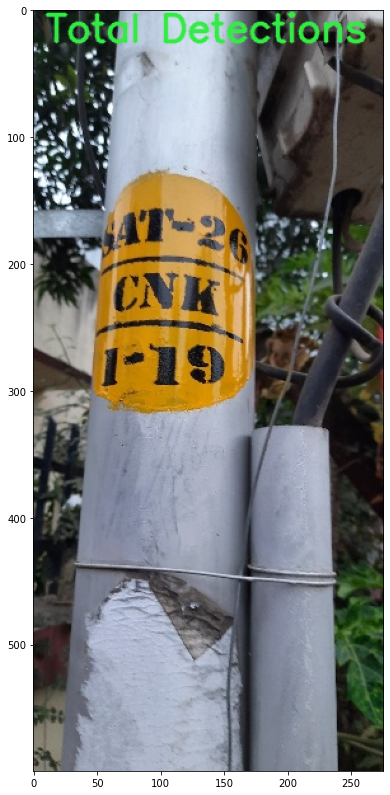

In [184]:
plt.figure(figsize=(20,14))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [155]:
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ-"
labelNames = [l for l in labelNames]

In [170]:
def clean_pole_no(number):
    number = number.replace('-/-', '/')
    pattern = "(?P<char>[" + re.escape('/') + "])(?P=char)+"
    a = re.sub(pattern, r'\1', number)
    clean_number = re.sub('(^/|/$)', '', a)
    return clean_number

In [171]:
def crop_pole_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    lower_yellow = np.array([120, 80, 0], np.uint8)
    upper_yellow = np.array([255, 255, 0], np.uint8)
    mask_yellow = cv2.inRange(image, lower_yellow, upper_yellow)
    yellow = cv2.bitwise_and(image, image, mask=mask_yellow)

    edges_yellow = cv2.Canny(yellow, 127, 255, apertureSize=3)

    contours_yellow, hierarchy = cv2.findContours(edges_yellow, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    boxes_yellow = []
    for contour in contours_yellow:
        x,y,w,h = cv2.boundingRect(contour)
        if cv2.contourArea(contour) < 5000:
        #cv2.rectangle(red, (x, y), (x + w, y + h), (0, 255, 0), 2)
            boxes_yellow.append([x,y, x+w,y+h])
            
    if len(boxes_yellow)> 0:    
        boxes_yellow = np.asarray(boxes_yellow)
        left = np.min(boxes_yellow[:,0])
        top = np.min(boxes_yellow[:,1])
        right = np.max(boxes_yellow[:,2])
        bottom = np.max(boxes_yellow[:,3])
        extracted_image = image[top:bottom, left:right]
    
        return extracted_image
    else:
        return None

In [172]:
def get_sorted_contours(contours, image_width):
    bboxes = []
    #area = []
    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        bboxes.extend([x, y, w, h, int(x+(w/2)), int(y+(h/2)), (w*h)])
        
    bboxes = np.reshape(np.asarray(bboxes), (-1, 7))

    # applying Non-maximum Suppression to remove overlapping bounding boxes
    nms_bboxes = non_max_suppression(bboxes, 0.3)
    #nms_bboxes = bboxes
    
    # Calculate mean area of the bounding boxes
    average_area = np.mean(np.asarray(nms_bboxes[:, 6]))
    #average_area = np.mean(np.asarray(bboxes[:, 6]))
    
    sorted_bboxes = sorted(nms_bboxes, key=lambda nms_bboxes:[nms_bboxes[5], nms_bboxes[4]])
    #sorted_bboxes = sorted(bboxes, key=lambda bboxes:[bboxes[5], bboxes[4]])
    
     # Sort the bounding boxes top-to-bottom then left-to-right
    for i in range(0, len(sorted_bboxes)):
        for j in range(0, len(sorted_bboxes)):
            if int(sorted_bboxes[j][5]*0.9) <= sorted_bboxes[i][5] <= int(sorted_bboxes[j][5]*1.10):
                if sorted_bboxes[i][4] < sorted_bboxes[j][4]:
                    temp = sorted_bboxes[i]
                    sorted_bboxes[i] = sorted_bboxes[j]
                    sorted_bboxes[j] = temp 
    
    return sorted_bboxes, average_area

In [173]:
def non_max_suppression(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # initialize the list of picked indexes
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,0] + boxes[:,2]
    y2 = boxes[:,1] + boxes[:,3]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list, add the index
        # value to the list of picked indexes, then initialize
        # the suppression list (i.e. indexes that will be deleted)
        # using the last index
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]
        
        # loop over all indexes in the indexes list
        for pos in range(0, last):
            # grab the current index
            j = idxs[pos]
            # find the largest (x, y) coordinates for the start of
            # the bounding box and the smallest (x, y) coordinates
            # for the end of the bounding box
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])
            # compute the width and height of the bounding box
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)
            # compute the ratio of overlap between the computed
            # bounding box and the bounding box in the area list
            overlap = float(w * h) / area[j]
            # if there is sufficient overlap, suppress the
            # current bounding box
            if overlap > overlapThresh:
                suppress.append(pos)
        # delete all indexes from the index list that are in the
        # suppression list
        idxs = np.delete(idxs, suppress)
    # return only the bounding boxes that were picked
    return boxes[pick]

In [186]:
def get_stmeter_no(imagepath):
    
    # Create empty array to store entire number
    full_number = []

    # Read the streetlight image
    image = cv2.imread(imagepath)
    
    image = crop_pole_image(image)
    
    if image is not None:
            
        # Convert the image to grayscale, and blur it to reduce noise
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    #blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        blurred = cv2.fastNlMeansDenoising(gray, None, 31, 7, 21)
    
    # Perform edge detection, find contours in the edge map, and sort the resulting contours from top-to-bottom
        edged = cv2.Canny(blurred, 30, 25)
        cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        cnts = sort_contours(cnts, method="top-to-bottom")[0]
    
    # Initialize the list of contour bounding boxes and associated characters that we'll be OCR'ing
        chars = []
    
    # Sort the contours from top to bottom and then left to right if they are in same line
        rect, avg_area = get_sorted_contours(cnts, image.shape[1])
    
    # Loop over the sorted bounding boxes
        for r in rect:
        # Compute the bounding box of the contour
            x = r[0]
            y = r[1]
            w = r[2]
            h = r[3]
        
        # extract the character and threshold it to make the character appear as *white* (foreground) on a *black* background, 
        # then grab the width and height of the thresholded image
            roi = gray[y:y + h, x:x + w]
            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        #thresh = thresh.astype('float32')
            (tH, tW) = thresh.shape
            # if the width is greater than the height, resize along the width dimension
           
            if tW > tH:
                try:
                    thresh = imutils.resize(thresh, width=32)
             
                except:
                    break
            #thresh = imutils.resize(thresh, width=32)
            # otherwise, resize along the height
            else:
                try:
                    thresh = imutils.resize(thresh, height=32)
             
                except:
                    break
                
             
            # re-grab the image dimensions (now that its been resized) and then determine how much we need to pad the width and
            # height such that our image will be 32x32
            (tH, tW) = thresh.shape
            dX = int(max(0, 32 - tW) / 2.0)
            dY = int(max(0, 32 - tH) / 2.0)
        
            # pad the image and force 32x32 dimensions
            padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
            left=dX, right=dX, borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))
            padded = cv2.resize(padded, (32, 32))
        
        # prepare the padded image for classification via our handwriting OCR model
            padded = padded.astype("float32") / 255.0
            padded = np.expand_dims(padded, axis=-1)
        
        # update our list of characters that will be OCR'd
            chars.append((padded, (x, y, w, h)))
            
    # extract the bounding box locations and padded characters
        boxes = [b[1] for b in chars]
        chars = np.array([c[0] for c in chars], dtype="float32")

    # OCR the characters using our handwriting recognition model
        preds = model.predict(chars)
    
        for (pred, (x, y, w, h)) in zip(preds, boxes):
    # find the index of the label with the largest corresponding
    # probability, then extract the probability and label
            i = np.argmax(pred)
            prob = pred[i]
            label = labelNames[i]
            
            aspect_ratio = w / h
       
            if (prob * 100 > 60) and (w*h > avg_area*0.25):
                if aspect_ratio > 3:
                    full_number.append('/')
                    continue
                
                else:   
                
                    # draw the prediction on the image
                  
                    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)
                    cv2.putText(image, label, (x - 5, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (150, 255, 255), 1)
                    full_number.append(label)
    
        full_number = [''.join(full_number)][0]
    
        pole_number = clean_pole_no(full_number)
        
        if len(pole_number)>20:
            pole_number = ""
    
    else:
        pole_number = ""
    
    
    print(f'Pole No: {pole_number}')
    
    
    return image, pole_number

Pole No: I2IE-I/INI/I-N
14


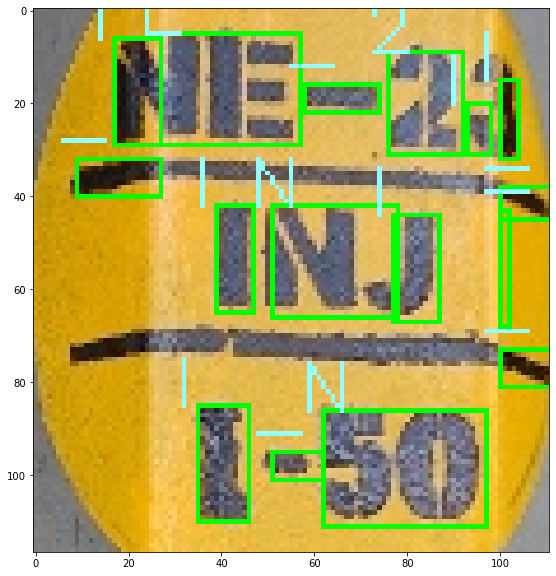

In [187]:
imagepath = 'D:\\Intelliza_Projects\\TPL\\OCR\\meter_ocr\\streetlight_images\\test_images\\nashik\\photo_painted_num\\49.jpg'

#imagepath = 'D:\\Intelliza_Projects\\TPL\\OCR\\meter_ocr\\streetlight_images\\test_images\\nashik\\stencil_clean.jpg'


image, pole_number = get_stmeter_no(imagepath)
print(len(pole_number))

plt.figure(figsize=(16,10))
#img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [137]:
def get_stmeter_no_old(imagepath):
    
    # Create empty array to store entire number
    full_number = []

    # Read the streetlight image
    image = cv2.imread(imagepath)
    
    if image is not None:
        if image.shape[1] > image.shape[0]:
            image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
            
        image = crop_pole_image(image)
    
    # Convert the image to grayscale, and blur it to reduce noise
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    #blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        blurred = cv2.fastNlMeansDenoising(gray, None, 31, 7, 21)
    
    # Perform edge detection, find contours in the edge map, and sort the resulting contours from top-to-bottom
        edged = cv2.Canny(blurred, 30, 25)
        cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        cnts = sort_contours(cnts, method="top-to-bottom")[0]
    
    # Initialize the list of contour bounding boxes and associated characters that we'll be OCR'ing
        chars = []
    
    # Sort the contours from top to bottom and then left to right if they are in same line
        rect, avg_area = get_sorted_contours(cnts, image.shape[1])
    
    # Loop over the sorted bounding boxes
        for r in rect:
        # Compute the bounding box of the contour
            x = r[0]
            y = r[1]
            w = r[2]
            h = r[3]
        
        # extract the character and threshold it to make the character appear as *white* (foreground) on a *black* background, 
        # then grab the width and height of the thresholded image
            roi = gray[y:y + h, x:x + w]
            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        #thresh = thresh.astype('float32')
            (tH, tW) = thresh.shape
            # if the width is greater than the height, resize along the width dimension
           
            if tW > tH:
                try:
                    thresh = imutils.resize(thresh, width=32)
             
                except:
                    break
            #thresh = imutils.resize(thresh, width=32)
            # otherwise, resize along the height
            else:
                try:
                    thresh = imutils.resize(thresh, height=32)
             
                except:
                    break
                 
            # re-grab the image dimensions (now that its been resized) and then determine how much we need to pad the width and
            # height such that our image will be 32x32
            (tH, tW) = thresh.shape
            dX = int(max(0, 32 - tW) / 2.0)
            dY = int(max(0, 32 - tH) / 2.0)
        
            # pad the image and force 32x32 dimensions
            padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
            left=dX, right=dX, borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))
            padded = cv2.resize(padded, (32, 32))
        
        # prepare the padded image for classification via our handwriting OCR model
            padded = padded.astype("float32") / 255.0
            padded = np.expand_dims(padded, axis=-1)
        
        # update our list of characters that will be OCR'd
            chars.append((padded, (x, y, w, h)))
            
    # extract the bounding box locations and padded characters
        boxes = [b[1] for b in chars]
        chars = np.array([c[0] for c in chars], dtype="float32")

    # OCR the characters using our handwriting recognition model
        preds = model.predict(chars)
    
        for (pred, (x, y, w, h)) in zip(preds, boxes):
    # find the index of the label with the largest corresponding
    # probability, then extract the probability and label
            i = np.argmax(pred)
            prob = pred[i]
            label = labelNames[i]
       
            if (prob * 100 > 30) and (w*h > avg_area*0.25):
                
            # draw the prediction on the image
                aspect_ratio = w / h
            
                if aspect_ratio > 3:
                    full_number.append('/')
                    continue
                elif aspect_ratio < 0.05:
                    full_number.append('1')
                else:                
                    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    cv2.putText(image, label, (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                    full_number.append(label)
    
        full_number = [''.join(full_number)][0]
    
        pole_number = clean_pole_no(full_number)
    
    else:
        pole_number = ""
    
    
    print(f'Pole No: {pole_number}')
    
    
    return image, pole_number

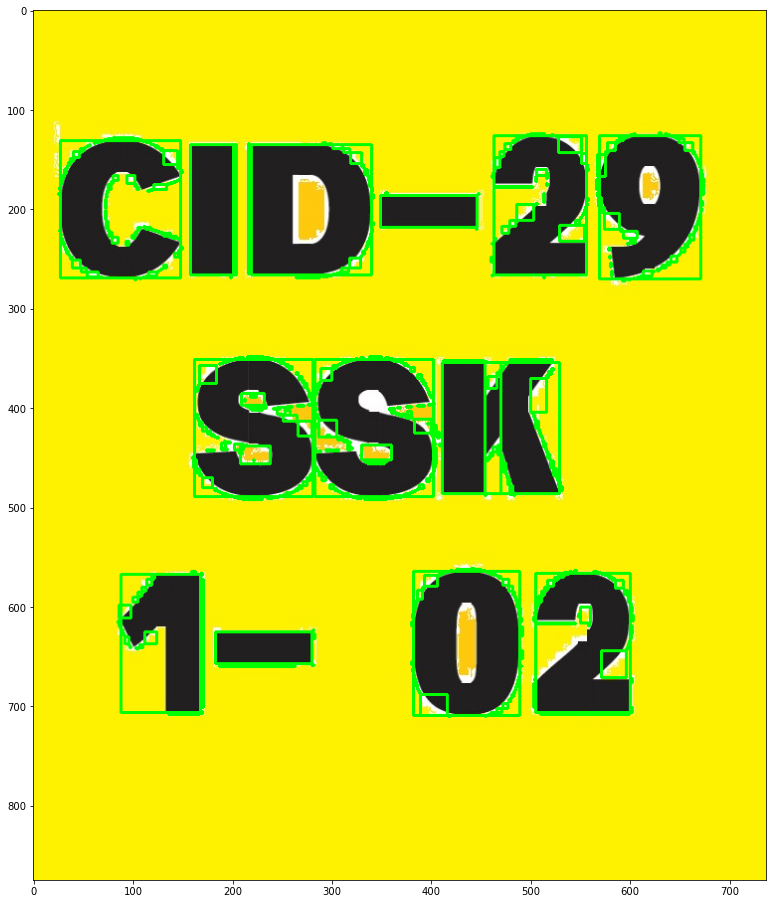

In [152]:
imagepath = 'D:\\Intelliza_Projects\\TPL\\OCR\\meter_ocr\\streetlight_images\\test_images\\nashik\\stencil_clean.jpg'

image = cv2.imread(imagepath)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.fastNlMeansDenoising(gray, None, 31, 7, 21)
    
# Perform edge detection, find contours in the edge map, and sort the resulting contours from top-to-bottom
edged = cv2.Canny(blurred, 30, 25)
#edged = cv2.Canny(gray, 30, 25)

cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="top-to-bottom")[0]

#rect, avg_area = get_sorted_contours(cnts, image.shape[1])

for c in cnts:
    # Compute the bounding box of the contour
    #x = r[0]
    #y = r[1]
    #w = r[2]
    #h = r[3]
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
plt.figure(figsize=(22,16))
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [9]:
pole_number_new = re.sub('[RJLMFWI-]','', pole_number)
pole_number_new

'165'